# Principles of Data Science

### Lecture 16: Hypothesis testing

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Hypothesis testing

- Today's lecture covers 
    - Hypothesis testing

- Learning objectives:
    - Understand the concept of a <font color="blue">hypothesis test</font>
    - Be able to distinguish <font color="blue">Type-I</font> and <font color="blue">Type-II errors</font> arise
    - Understand how to quanitfy the <font color="blue">statistical power</font> of a test
    - Be able to proove that the most powerful test is the <font color="blue">Neyman-Pearson test</font>

## Hypothesis testing

- Goodness of fit tests are a type of hypothesis test
- Compare the model we fit (call it hypothesis $H_0$) against all other possible hypotheses
- We can of course be much more powerful if we compare two specific hypotheses
    - Often referred to as the *null hypothesis* ($H_0$) and the *alternate hypothesis* ($H_1$)

## Hypothesis Testing

- Let $X$ be some *test statistic*
- Use our two hypotheses (or models) to determine the distribution of $X$ under each of $H_0$ and $H_1$
$$ P(X|H_0) \quad \text{ and } \quad P(X|H_1) $$
- Then determine how much of $H_0$ or $H_1$ falls above or below a certain value (or threshold)
- <font color="green">*See handwritten notes in lecture*</font>

<img src="plots/hypothesis_test.png" alt="drawing" width="800">

## The Neyman-Pearson Lemma

- But what is the best choice of the test statistic?
- In order to find out we need to *maximise* the power
- <font color="green">*See handwritten notes in lecture*</font>
- Result turns out to be the likelihood ratio:

$$ T = -2\ln \left( \frac{L(X|H_0)}{L(X|H_1)} \right) = -2\Delta\ln L' $$

- This is known as the <font color="blue">*Neyman-Pearson Lemma*</font>
- Due to Wilks' theorem we know it is distributed as a $\chi^2$ with 1 d.o.f.

# <font color="darkred">*Musical interlude...*</font>

## A demonstration of Hypothesis testing

- A real life example searching for the Higgs, $H\to\gamma\gamma$

In [1]:
import numpy as np
np.random.seed(21187)
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')
from iminuit import Minuit, cost

In [2]:
# set up model parameters
xrange = (100,150)
Ns = 850
Nb = 200e3
mu = 125
sg = 1
p  = 0.04
sa, sb = (xrange[0]-mu)/sg, (xrange[1]-mu)/sg
bb = (xrange[1]-xrange[0])*p

In [3]:
# define functions for the pdfs
from scipy.stats import truncexpon, truncnorm

def bkg_model(x, p):
    endp = (xrange[1]-xrange[0])*p
    srtp = xrange[0]
    scl = 1/p
    return truncexpon.pdf(x, b=endp, loc=srtp, scale=scl)

def sig_model(x, mu, sg):
    a, b = (xrange[0]-mu)/sg, (xrange[1]-mu)/sg
    return truncnorm.pdf(x, a=a, b=b, loc=mu, scale=sg)

def tot_model(x, Ns, mu, sg, Nb, p):
    return Ns*sig_model(x,mu,sg) + Nb*bkg_model(x,p)
 
def tot_density(x, Ns, mu, sg, Nb, p):
    return Ns+Nb, tot_model(x, Ns, mu, sg, Nb, p)

In [4]:
# generate a pseudo-dataset
Ns = np.random.poisson(Ns)
Nb = np.random.poisso n(Nb)

xb = truncexpon.rvs(b=bb, loc=xrange[0], scale=1/p, size=Nb)
xs = truncnorm.rvs(a=sa, b=sb, loc=mu, scale=sg, size=Ns)
dset = np.concatenate( [xb,xs] )

In [5]:
# Setup a fit
nll = cost.ExtendedUnbinnedNLL( dset, tot_density )
mi = Minuit( nll, Ns=Ns, mu=mu, sg=sg, Nb=Nb, p=p )

In [56]:
# Run the fit for the null hypothesis
mi.values['Ns'] = 0
mi.fixed['Ns'] = True
mi.fixed['mu'] = True
mi.fixed['sg'] = True
mi.migrad()
mi.hesse()

bo_vals = list(mi.values)
bo_min = mi.fval

print(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.988e+06                 │              Nfcn = 372              │
│ EDM = 3.75e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [7]:
# Run the fit for the alternate hypothesis
mi.values['Ns'] = Ns
mi.fixed['Ns'] = False
mi.migrad()
mi.hesse()  

sb_vals = list(mi.values)
sb_min = mi.fval

print(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.988e+06                 │              Nfcn = 343              │
│ EDM = 6.1e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

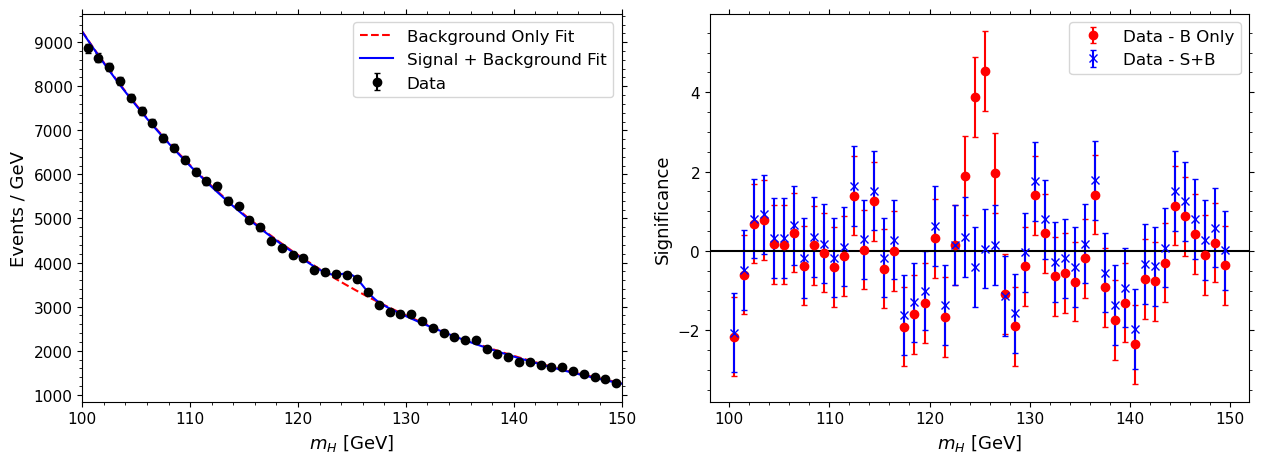

In [47]:
# make a nice plot of the two fits
nh, xe = np.histogram(dset, bins=50, range=xrange)
cx = 0.5*(xe[1:]+xe[:-1])
bw = xe[1]-xe[0]

fig, ax = plt.subplots(1,2, figsize=(12.8,4.8))
x = np.linspace(*xrange,200)
ax[0].errorbar( cx, nh, nh**0.5, fmt='ko', label='Data')
ax[0].plot(x, bw*tot_model(x, *bo_vals), 'r--', label='Background Only Fit')
ax[0].plot(x, bw*tot_model(x, *sb_vals), 'b-', label='Signal + Background Fit')
ax[0].legend()
ax[0].set_xlabel( '$m_H$ [GeV]' )
ax[0].set_ylabel( f'Events / GeV')
ax[0].set_xlim(*xrange)
ax[0].legend()

# make a plot of the "pull" residuals of each
bo_y = bw*tot_model( cx, *bo_vals )
sb_y = bw*tot_model( cx, *sb_vals )

bo_p = (nh - bo_y)/nh**0.5
sb_p = (nh - sb_y)/nh**0.5

ax[1].errorbar( cx, bo_p, np.ones_like(bo_p), fmt='ro', label='Data - B Only')
ax[1].errorbar( cx, sb_p, np.ones_like(sb_p), fmt='bx', label='Data - S+B')
ax[1].set_xlabel( '$m_H$ [GeV]' )
ax[1].set_ylabel( f'Significance')
ax[1].axhline(0, c='k')
ax[1].legend()


**NOTICE we can see the signal by eye here! It's obvious we should be expecting a letter from Stockholm**

In [42]:
## do a chisq goodness of fit test for the background only
from scipy.stats import chi2
bo_chisq = np.sum( (bo_y-nh)**2 / nh )
bo_ndof = len(xe) - 1 - 5
bo_pval = 1 - chi2.cdf(bo_chisq, bo_ndof)
bo_signif = chi2.ppf(1-bo_pval,1)**0.5

In [55]:
# do a Neyman-Pearson Test
T = bo_min - sb_min
sb_chisq = T
sb_ndof = 1
sb_pval = 1 - chi2.cdf(sb_chisq, sb_ndof)
sb_signif = chi2.ppf(1-sb_pval,1)**0.5


In [44]:
print( f'chi2 g.o.f = {bo_signif:4.1f} sigma')
print( f'NP test    = {sb_signif:4.1f} sigma')

chi2 g.o.f =  3.9 sigma
NP test    =  7.1 sigma


- Clearly see that the $\chi^2$ goodness of fit test is not remotely powerful
- The Neyman-Pearson test is (increase the significance from ~4 to ~7)
- Think about what this means in terms of the probabilities!!! (~6 orders of magnitude)

In [51]:
print( f'chi2 g.o.f = {bo_pval:4.2g}') 
print( f'NP test    = {sb_pval:4.2g}')

chi2 g.o.f = 8.6e-05
NP test    = 1.4e-12


# End of Lecture 16

By the end of this lecture you should:
   - Understand the concept of a <font color="blue">hypothesis test</font>
   - Be able to distinguish <font color="blue">Type-I</font> and <font color="blue">Type-II errors</font> arise
   - Understand how to quanitfy the <font color="blue">statistical power</font> of a test
   - Be able to proove that the most powerful test is the <font color="blue">Neyman-Pearson test</font>